## **ResNet-50을 통해 Augmentation 비교하기**  
**No Augmentation vs. 기본 Augmentation vs. 기본+CutMix vs. 기본+Mixup**


#### **1. 데이터 셋 준비**  
#### **2. 데이터 전처리**  
#### **3. ResNet-50 모델 구성**
#### **4. 모델 훈련**  
#### **5. 결과 시각화**  
#### **6. 결론**  
#### **7. 고찰**  
#### **참고문헌**

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds 
import numpy as np

print(tf.__version__)
print(np.__version__)

2.9.0
1.22.3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---

### **1. 데이터 셋 준비**  


In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

2023-06-27 17:30:09.528023: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


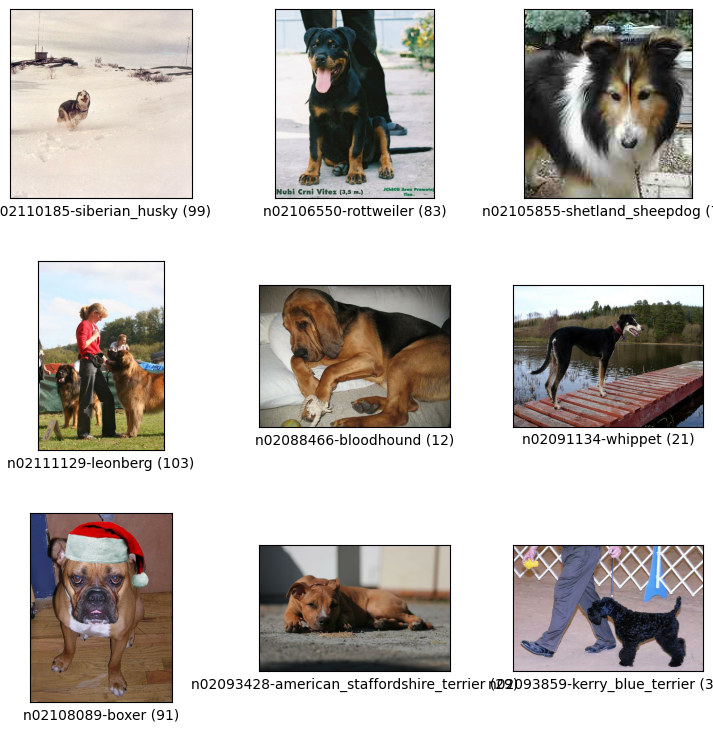

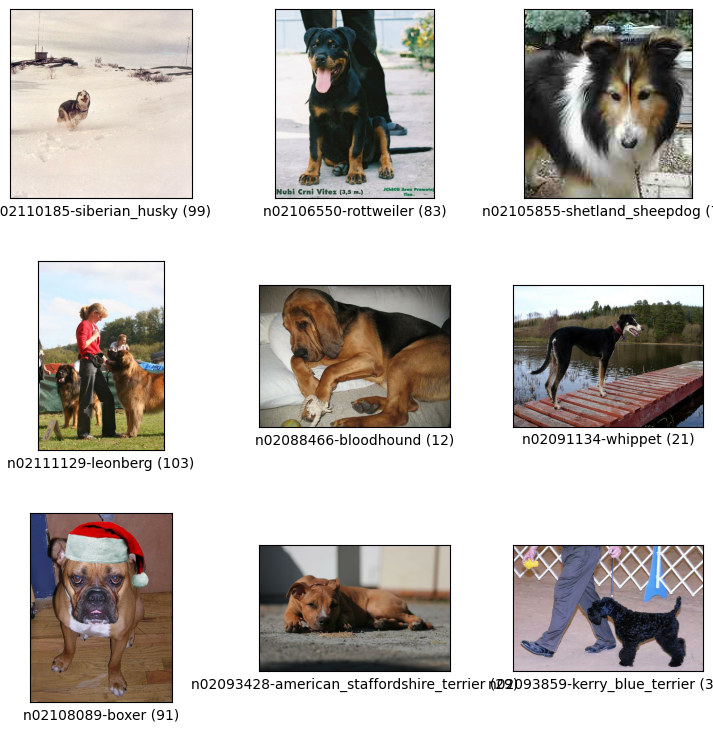

In [4]:
tfds.show_examples(ds_train, ds_info)

In [5]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

---

 
### **2. 데이터 전처리**  


In [6]:
# 기본 전처리 함수 (train, test 모두 적용)
# 입력받은 이미지를 0~1 사이의 float32로 normalize, (224, 224)로 resize
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# 기본 Augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# 라벨 원-핫 인코딩
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label


In [7]:
# cutmix
# 이미지 a를 바탕 이미지로 하고 삽입할 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max, image_size_x, image_size_y

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max,image_size_x, image_size_y, num_classes=120):
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

# batch_size에 대해 cutmix
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max, image_size_x, image_size_y = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_size_x, image_size_y))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


In [8]:
# mixup
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

# batch_size에 대해 mixup
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [9]:
# 데이터 셋 전처리 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    if not is_test and with_aug:
        ds = ds.map(augment)
        
    ds = ds.batch(batch_size)
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix,num_parallel_calls=2)
        
    elif not is_test and with_mixup:
        ds = ds.map(mixup,num_parallel_calls=2)
        
    else:
        ds = ds.map(onehot,num_parallel_calls=2)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [10]:
train = apply_normalize_on_dataset(ds_train)                                            # No Augmentation
aug_train = apply_normalize_on_dataset(ds_train, with_aug=True)                         # 기본 Augmentation
cutmix_train = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)    # 기본 + cutmix
mixup_train = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)      # 기본 + mixup

test = apply_normalize_on_dataset(ds_test, is_test=True)

---

### **3. ResNet-50 모델 구성**


In [11]:
# imagenet으로 훈련된 resnet50
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,  # imagenet과 데이터셋이 서로 다른 클래스를 가짐 
                            # : 마지막에 추가해야하는 fully connected layer의 구조(뉴련의 개수)가 다름
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 기본 Augmentation 모델
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 기본 + Cutmix
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

# 기본 + Mixup
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94765736/94765736 [==============================] - 15s 0us/step


---

### **4. 모델 훈련**  


In [ ]:
EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수

# No augmentation
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug= resnet50.fit(
    train, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=test,
    verbose=2,
    use_multiprocessing=True,
)
# 73m 19.1s

In [ ]:
# 기본 Augmentation
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    aug_train, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=test,
    verbose=2,
    use_multiprocessing=True,
)
# 72m 0.8s

In [ ]:
# 기본 + cutmix
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    cutmix_train, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=test,
    verbose=2,
    use_multiprocessing=True,
)
# 71m 46.2s

In [ ]:
# 기본 + mixup
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    mixup_train, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=test,
    verbose=2,
    use_multiprocessing=True,
)
# 72m 22.3s

---

### **5. 결과 시각화**  


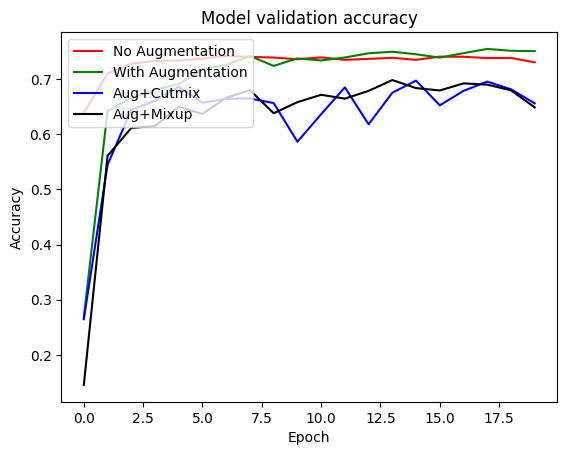

In [17]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Aug+Cutmix', 'Aug+Mixup'], loc='upper left')
plt.show()

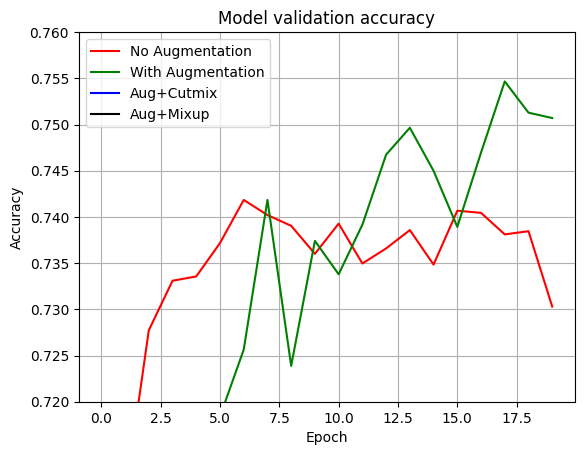

In [18]:
# 최고 성능 부분 확대
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'Aug+Cutmix', 'Aug+Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.72, 0.76)   
plt.show()

---

### **6. 결론**  


- epoch=20에 가까워 질수록 기본 Augmentation을 적용한 데이터 셋의 정확도가 가장 높음.  
- 기본+cutmix, 기본+mixup은 augmentation을 적용하지 않은 기본 데이터셋에 비해서도 낮은 정확도를 띔.  


---

### **7. 고찰**  



![]()
<img src="https://imgur.com/mNn3O1d.png" width="500px" height="300px" title="px(픽셀) 크기 설정" alt="Markdown Image"></img><br/>  

- Yun, Sangdoo, et al., 2019 의 fig 2.에서 epochs>=200 부터 cutmix의 성능이 확연히 보이는 것을 보아  
cutmix와 mixup의 성능을 보이기에는 이번 시도에서 epoch 부족으로 인해 다음과 같은 결과를 띈 것으로 보임

---

### **참고문헌**

- Yun, Sangdoo, et al. "Cutmix: Regularization strategy to train strong classifiers with localizable features." Proceedings of the IEEE/CVF international conference on computer vision. 2019.  
- Zhang, Hongyi, et al. "mixup: Beyond empirical risk minimization." arXiv preprint arXiv:1710.09412 (2017).